In [ ]:
import pandas as pd
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import dask.dataframe as dd
import pandas as pd
import numpy as np


# Read the CSV file using Dask

# from within google colab
df = dd.read_parquet('/content/drive/MyDrive/ZHAW/fake_news/data/news_cleaned_truncated_small.parquet.gzip',on_bad_lines='skip', blocksize='64MB')

# locally
# dask_df = dd.read_parquet('./news_cleaned_truncated_extra_small.parquet.gzip',on_bad_lines='skip')

# create index with dask using continuous numbers
# dask_df = dask_df.reset_index()
# dask_df.set_index('index')

# len(df.index)
print(df.npartitions)
print(df.columns)

1
Index(['type', 'content'], dtype='object')


In [ ]:
%alias_magic t timeit

Created `%t` as an alias for `%timeit`.
Created `%%t` as an alias for `%%timeit`.


**Sampling the data**

In [ ]:
df = df.groupby('type').apply(lambda group: group.sample(frac=0.01), meta=df)
df = df.persist()
len(df.index)

81256

**Some information about the data**

In [ ]:
# show some infos about the dataframe
print (df.columns)

# show the first 10 rows
print(df.head(10))


type_counts = df['type'].value_counts().compute()
print (type_counts)

Index(['type', 'content'], dtype='object')
         type                                            content
2125946  bias  France to implement obligations on Mistral shi...
5521778  bias  Dershowitz: Jimmy Carter Broke The Law In Fund...
4259721  bias  Coup in the United States. Congress declared e...
3017370  bias  Swedish aid worker Anders Kompass has been sus...
3360264  bias  Judicial Watch, on the heels of the latest Dem...
576694   bias  Numerous military veterans groups have express...
2175805  bias  \n\nDIGG THIS\n\nAmerican History X is one of ...
1512117  bias  Michael Moore's buzz from riding his high-hors...
4891917  bias  Dear readers, we are excited to announce that ...
5115475  bias  Atheist monument unveiled in Florida\n\nA grou...
reliable      19132
political     16572
bias          11390
fake           8947
conspiracy     8312
rumor          4812
unknown        3715
unreliable     2988
clickbait      2319
junksci        1175
satire         1129
hate            765
Na

In [ ]:
# remove duplicate rows
df = df.drop_duplicates(subset='content')
df = df.persist()
len(df.index)

68019

In [ ]:
type_counts = df['type'].value_counts().compute()
print (type_counts)

reliable      18655
political     12673
bias           8578
fake           7985
conspiracy     6489
rumor          4550
unknown        2961
clickbait      2276
unreliable     1202
junksci         974
satire          932
hate            744
Name: type, dtype: int64


# Removal of names

In [ ]:
# get rid of names
import spacy

# Load the spaCy model
nlp = spacy.load('en_core_web_sm')

In [ ]:
import time

# Function to remove names
def remove_names(text):
    doc = nlp(text)
    for ent in doc.ents:
        if ent.label_ in ['PERSON']:
            text = text.replace(ent.text, '')
    return text

for i in range(1,12):
  dfc = df.copy()
  dfc = dfc.repartition(npartitions=i)
  # dfc = dfc.persist()

  # Start timing
  start_time = time.time()

  dfc['content'] = dfc.map_partitions(lambda partition: partition['content'].apply(remove_names))
  dfcp = dfc.persist()

  # End timing
  end_time = time.time()

  # Calculate and print the duration
  duration = end_time - start_time
  print(f"The map_partitions function took {duration} seconds to execute for {i} partitions.")

In [ ]:
# storing the cleaned dataframe
df = dfcp

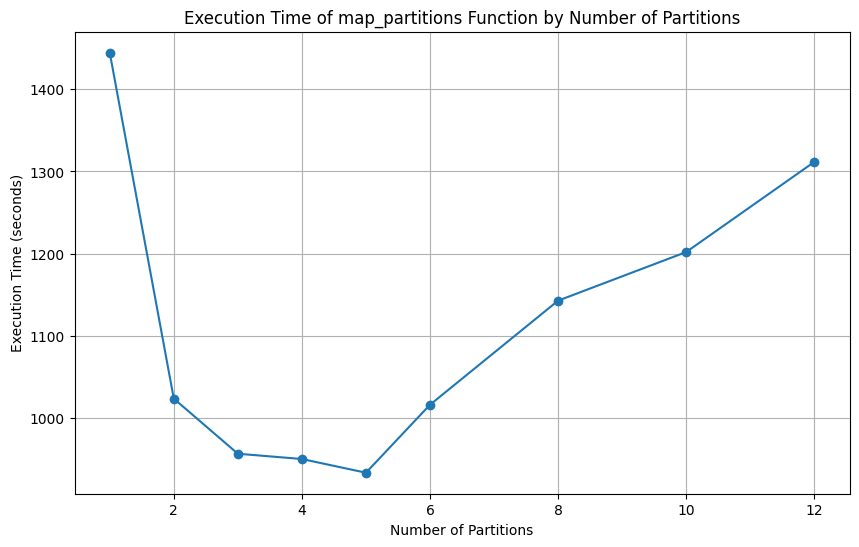

In [ ]:
import matplotlib.pyplot as plt

# Data
partitions = [1, 2, 3, 4, 5, 6, 8, 10, 12]
execution_times = [
    1444.5276398658752, 1023.5975570678711, 956.5397212505341,
    950.1171228885651, 933.437178835632, 1016.1484487056732, 1142.84206199646,
    1201.9860441684723, 1311.6681382656097
]

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(partitions, execution_times, marker='o')
plt.title('Execution Time of map_partitions Function by Number of Partitions')
plt.xlabel('Number of Partitions')
plt.ylabel('Execution Time (seconds)')
plt.grid(True)
plt.show()


In [ ]:
len(df.index)


68019

# Removal of stop words

In [ ]:
# Clean up text data before feeding it into a word embedding model
# Remove irrelevant or noisy elements like special characters, numbers, stop words,
# and normalize the text (like lowercasing)
import re
from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')

def clean_text(text):
    # Convert text to lowercase
    text = text.lower()

    # Remove special characters and digits
    text = re.sub(r'[^a-zA-Z\s]', '', text)

    # Remove stopwords (common words that may not add much meaning)
    stop_words = set(stopwords.words('english'))
    text = ' '.join([word for word in text.split() if word not in stop_words])

    return text


#df['content'] = df.map_partitions(lambda partition: partition['content'].apply(clean_text))
#df = df.persist()


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
for i in range(2, 50, 2):
  dfc = df.copy()
  dfc = dfc.repartition(npartitions=i)
  # dfc = dfc.persist()

  # Start timing
  start_time = time.time()

  dfc['content'] = dfc.map_partitions(lambda partition: partition['content'].apply(clean_text))
  dfcp = dfc.persist()

  # End timing
  end_time = time.time()

  # Calculate and print the duration
  duration = end_time - start_time
  print(f"The map_partitions function took {duration} seconds to execute for {i} partitions.")

The map_partitions function took 12.467677593231201 seconds to execute for 2 partitions.
The map_partitions function took 15.401684045791626 seconds to execute for 4 partitions.
The map_partitions function took 18.624863624572754 seconds to execute for 6 partitions.
The map_partitions function took 19.611995697021484 seconds to execute for 8 partitions.
The map_partitions function took 19.31348419189453 seconds to execute for 10 partitions.
The map_partitions function took 19.771729469299316 seconds to execute for 12 partitions.
The map_partitions function took 21.18539261817932 seconds to execute for 14 partitions.
The map_partitions function took 19.88782000541687 seconds to execute for 16 partitions.
The map_partitions function took 19.32714819908142 seconds to execute for 18 partitions.
The map_partitions function took 19.571991443634033 seconds to execute for 20 partitions.
The map_partitions function took 20.1028311252594 seconds to execute for 22 partitions.
The map_partitions f

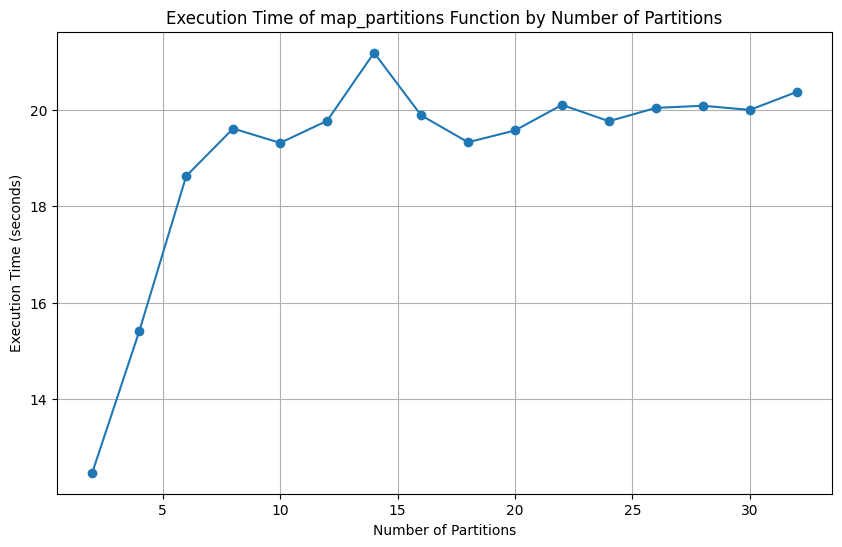

In [ ]:
import matplotlib.pyplot as plt

# Data
partitions = [2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32]

execution_times = [
    12.467677593231201, 15.401684045791626, 18.624863624572754,
    19.611995697021484, 19.31348419189453, 19.771729469299316,
    21.18539261817932, 19.88782000541687, 19.32714819908142,
    19.571991443634033, 20.1028311252594, 19.76437759399414,
    20.040009021759033, 20.084640502929688, 19.998685836791992,
    20.37179398536682
]


# Plotting
plt.figure(figsize=(10, 6))
plt.plot(partitions, execution_times, marker='o')
plt.title('Execution Time of map_partitions Function by Number of Partitions')
plt.xlabel('Number of Partitions')
plt.ylabel('Execution Time (seconds)')
plt.grid(True)
plt.show()

In [ ]:
df = dfcp
df_pandas = df.compute()


In [ ]:
df_pandas.to_parquet('news_cleaned_truncated_small_68k_samples_no_tokenization.parquet.gzip', compression='gzip')

# Tokenization using DistilBERT

In [ ]:
# let's go for distilBERT and tokenization
!pip install transformers

In [ ]:
from transformers import DistilBertTokenizer


# Load the DistilBERT tokenizer
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

def tokenize_text(text):
    # Tokenize the text and return the input IDs
    return tokenizer.encode(text, add_special_tokens=True, truncation=True, max_length=512)


df['content_tokenized'] = df.map_partitions(lambda partition: partition['content'].apply(tokenize_text))
df = df.persist()


In [ ]:
df.head()

,type,content,content_tokenized
3637243,clickbait,black lives matter blm gaining public attentio...,"[101, 2304, 3268, 3043, 1038, 13728, 8550, 227..."
1932734,clickbait,deeppocketed republicans threaten withhold sup...,"[101, 2784, 6873, 19869, 3064, 10643, 15686, 2..."
1899477,clickbait,deserted stone alleyway joyful chorus halleluj...,"[101, 12768, 2962, 8975, 4576, 6569, 3993, 716..."
1756062,clickbait,new study conservatives tested low iq childhoo...,"[101, 2047, 2817, 11992, 7718, 2659, 26264, 55..."
1850889,clickbait,asked speak republican convention legendary fo...,"[101, 2356, 3713, 3951, 4680, 8987, 2374, 2873..."


In [ ]:
len(df.index)

68246

In [ ]:
df_pandas = df.compute()

In [ ]:
df_pandas.to_parquet('news_cleaned_truncated_small_100k_samples.parquet.gzip', compression='gzip')